<a href="https://colab.research.google.com/github/joeljoyjj12/NeRF-Minimal/blob/main/NeRF_Minimal_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import os
import glob
import imageio
from PIL import Image
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES =  32
POS_ENCODE_DIMS = 16
EPOCHS = 800

name='hotdog' # name of data

## Data Preprocessing LLF

In [ ]:
# Converting images to array format and saving
# img_arr

img_target=120
pose_file='/content/poses_bounds.npy'
img_folder='/content/room_images'

data_new=np.load(pose_file)
imgs_name=sorted(os.listdir(img_folder))
img_arr=[]

for img_path in imgs_name:
  imag=tf.keras.preprocessing.image.load_img(f'{img_folder}/{img_path}',target_size=(img_target,img_target))
  temp_arr=tf.keras.preprocessing.image.img_to_array(imag)/255
  img_arr.append(temp_arr)

img_arr=np.array(img_arr)
plt.imshow(img_arr[0])

# Save img array
# np.save('fern_arr',img_arr)


FileNotFoundError: ignored

In [ ]:
print(imgs_name)

['DJI_20200226_143850_006.JPG', 'DJI_20200226_143851_396.JPG', 'DJI_20200226_143852_910.JPG', 'DJI_20200226_143854_410.JPG', 'DJI_20200226_143855_969.JPG', 'DJI_20200226_143857_455.JPG', 'DJI_20200226_143858_657.JPG', 'DJI_20200226_143900_082.JPG', 'DJI_20200226_143901_419.JPG', 'DJI_20200226_143902_603.JPG', 'DJI_20200226_143903_817.JPG', 'DJI_20200226_143905_272.JPG', 'DJI_20200226_143906_682.JPG', 'DJI_20200226_143908_032.JPG', 'DJI_20200226_143909_533.JPG', 'DJI_20200226_143910_733.JPG', 'DJI_20200226_143912_008.JPG', 'DJI_20200226_143913_463.JPG', 'DJI_20200226_143914_572.JPG', 'DJI_20200226_143917_136.JPG', 'DJI_20200226_143918_576.JPG', 'DJI_20200226_143920_018.JPG', 'DJI_20200226_143921_201.JPG', 'DJI_20200226_143924_817.JPG', 'DJI_20200226_143926_241.JPG', 'DJI_20200226_143927_413.JPG', 'DJI_20200226_143928_568.JPG', 'DJI_20200226_143929_618.JPG', 'DJI_20200226_143930_936.JPG', 'DJI_20200226_143933_787.JPG', 'DJI_20200226_143935_646.JPG', 'DJI_20200226_143936_861.JPG', 'DJI_20

In [ ]:
# Loading poses from npy file

data_new=np.load(pose_file)
print(data_new.shape)

near_bound,far_bound=data_new[19,-2:]
pose_matrix=np.reshape(data_new[0][:15],(3,5))

img_height=pose_matrix[0,-1]
img_width=pose_matrix[1,-1]
focal_img=pose_matrix[2,-1]
camera_fov=np.arctan(img_height/2/focal_img,dtype='float32')*2

print("Near and far",near_bound,far_bound)
print(pose_matrix)
print(f"Height : {img_height}, Width : {img_width}, Focal Length: {focal_img}")
print(f"Camera angle : {camera_fov}")



NameError: ignored

In [ ]:
# Forming pose matrix with final row 0 0 0 1

no_imgs=data_new.shape[0]
print(no_imgs)

pose_matrix=data_new[:,:15]
pose_matrix=np.reshape(pose_matrix,(no_imgs,3,5))
pose_matrix=pose_matrix[:,:,:4]
pose_matrix.shape

# Tiling
tile_arr=np.tile(np.array([0,0,0,1]),(no_imgs,1,1))
poses_conc=np.concatenate((pose_matrix, tile_arr), axis=1,dtype='float32')

print(poses_conc[37])

41
[[-1.9138241e-03  9.9756658e-01  6.9693848e-02  3.2123687e+00]
 [ 9.9898434e-01 -1.2302416e-03  4.5041684e-02  1.9202514e+00]
 [ 4.5017820e-02  6.9709264e-02 -9.9655104e-01  3.9936665e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [ ]:
# Combining poses and images into a dictionary
# img_arr - Image array, poses_conc - pose matrix
# dict keys :- images, poses, focal

pos_img_dict=dict()

pos_img_dict["images"] = img_arr
pos_img_dict["poses"] = poses_conc
# pos_img_dict["focal"] = (img_height/2) np.tan(camera_fov/2)
pos_img_dict["focal"] = img_target/2/np.tan(camera_fov/2)

np.save('room_data.npy',pos_img_dict)

new_dict = np.load('room_data.npy', allow_pickle='TRUE')


In [ ]:
# Trial 
from google.colab import files

data_np=files.upload()

### Download and Load Data

##### Loading Data

<class 'dict'>
Keys are : ['images', 'poses', 'focal']
Image shape : (200, 100, 100, 3)
Image 0 :


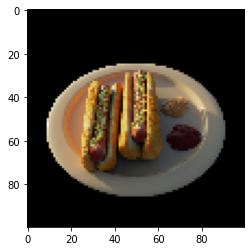

[[-1.          0.          0.          0.        ]
 [ 0.         -0.73411     0.67903066  2.7372601 ]
 [ 0.          0.67903066  0.73410994  2.9592917 ]
 [ 0.          0.          0.          1.        ]]
152.77776678914313
float32


In [ ]:
# ------------------------------ Original Data Berkeley----------------------------------------#
# Download the data if it does not already exist.
# file_name = "tiny_nerf_data.npz"
# url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"
# if not os.path.exists(file_name):
#     data = keras.utils.get_file(fname=file_name, origin=url)

# data = np.load(data) # data from url
#--------------------------------------------------------------------------------------------#

# Custom Data 
data = np.load(f'/content/{name}_data.npy',allow_pickle=True)

# Loading data
data=data.item()
print(type(data))


print(f'Keys are : {[k for k in data.keys()]}')  # Keys in data

images = data["images"]
im_shape = images.shape

print(f"Image shape : {im_shape}")

(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])   # each pose is 4x4 array

# Plot a random image from the dataset for visualization.
# rand_int=np.random.randint(0,num_images)
rand_int=0

print(f'Image {rand_int} :')
plt.imshow(images[rand_int])
plt.show()

plt.imsave(f'{name}_sample.jpeg',images[rand_int])

print(poses[rand_int])
print(focal)

poses=poses.astype('float32')
print(poses.dtype)

#### Encoding position into Higher dimension

In [ ]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """

    # print("Inside encode : ",x.shape)

    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))

    # print("Inside encode : ",len(positions),len(positions[0]),len(positions[0][0]))
    return tf.concat(positions, axis=-1)


#### Origin point and direction vector of Rays

In [ ]:
def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )


    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)

#### Rendering and Flattening ray

In [ ]:
def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)

    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples

        # print("t_vals before")
        # print(t_vals.shape)

        t_vals = t_vals + noise

        # print("t_vals after")
        # print(t_vals.shape)

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])


    #$$$$$$$$$$$$$$$$$$$$$$$$$$$###################
    print(rays.shape)
    print(rays_flat.shape)


    rays_flat = encode_position(rays_flat)

    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$####################
    print("rays_pos_encode shape : ",rays_flat.shape)

    return (rays_flat, t_vals)

#### Mapping individual pose to flattened rays and sampling it

In [ ]:
# ---------  Original near = 2.0 far=6.0
def map_fn(pose,near=1.8,far=6.0):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=near,# change made
        far=far,  # change made
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)

### Preparing images for training and validation

In [ ]:
# Create the training split.
split_index = int(num_images * 0.9)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

(100, 100, 32, 3)
(320000, 3)
rays_pos_encode shape :  (320000, 99)
(100, 100, 32, 3)
(320000, 3)
rays_pos_encode shape :  (320000, 99)


In [ ]:
# print(train_images.shape)
# print(train_poses.shape)
# print(len(train_pose_ds),train_pose_ds)
# print(len(train_img_ds),train_img_ds)

# print("\n \n Train ray_ds \n")
# print(len(train_ray_ds),train_ray_ds)

# Creating the NeRF Model

In [ ]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=128, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

# Training

In [ ]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.

        #------------------------ Plotting part -----------------------------------#
        if epoch%3==0:
          fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
          ax[0].imshow(keras.preprocessing.image.array_to_img(test_recons_images[0]))
          ax[0].set_title(f"Predicted Image: {epoch:04d}")

          ax[1].imshow(keras.preprocessing.image.array_to_img(depth_maps[0, ..., None]))
          ax[1].set_title(f"Depth Map: {epoch:04d}")

          ax[2].plot(loss_list)
          ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
          ax[2].set_title(f"Loss Plot: {epoch:04d}")

          fig.savefig(f"{name}_images/{epoch:03d}.png")
          plt.show()
          plt.close()
        #--------------------------------------------------------------------------#


In [ ]:
print(H,W)

100 100


In [ ]:
#------------------------------------------------------------------------------#
#To save weights in each iteration

checkpoint_filepath = f'weights_500_{name}.ckpt'
checkp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    save_weights_only=True)

#------------------------------------------------------------------------------#

num_pos = H * W * NUM_SAMPLES

nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos) # Creating new model

# ----------------------Loading saved model------------------------#
# nerf_model = keras.models.load_model(f'/content/{name}_NeRF_766.h5')
#------------------------------------------------------------------# 

#---------------------------------#
# nerf_model.load_weights('/content/weights_1000_silica.h5')
#---------------------------------#


model = NeRF(nerf_model)

#---------------***Loading Weights***------------------------------------------#
model.load_weights(f'weights_766_{name}.ckpt')
#------------------------------------------------------------------------------#

model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists(f"{name}_images"):
    os.makedirs(f"{name}_images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor(),checkp],
    steps_per_epoch=split_index // BATCH_SIZE,
)

Epoch 1/800
 9/36 [======>.......................] - ETA: 19s - loss: 0.0578 - psnr: 12.4024

KeyboardInterrupt: ignored

#### Fit Separate

In [ ]:
model = keras.models.load_model('/content/NeRF_2000_iter_silica.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320000, 99)  0           []                               
                                ]                                                                 
                                                                                                  
 dense (Dense)                  (None, 320000, 128)  12800       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 320000, 128)  16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 320000, 128)  16512       ['dense_1[0][0]']            

In [ ]:
# Callback separate
class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.

        #------------------------ Plotting part -----------------------------------#
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.preprocessing.image.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:04d}")

        ax[1].imshow(keras.preprocessing.image.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:04d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:04d}")

        fig.savefig(f"images/{epoch:03d}.png",transparent=True)
        # plt.show()
        # plt.close()
        #--------------------------------------------------------------------------#

In [ ]:
test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images_set_2"):
    os.makedirs("images_set_2")

TypeError: ignored

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    # epochs=EPOCHS,
    epochs=600,
    callbacks=[TrainMonitor()],
    steps_per_epoch=split_index // BATCH_SIZE,
)

#### GIF

In [ ]:
def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.2}
    imageio.mimsave(name_gif, images, "GIF", **kargs)

create_gif(f"{name}_images/*.png", f"training_{name}.gif")

100%|██████████| 261/261 [00:03<00:00, 71.64it/s]


In [ ]:
nerf_model=model.nerf_model
nerf_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 320000, 99)  0           []                               
                                ]                                                                 
                                                                                                  
 dense_18 (Dense)               (None, 320000, 256)  25600       ['input_3[0][0]']                
                                                                                                  
 dense_19 (Dense)               (None, 320000, 256)  65792       ['dense_18[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 320000, 256)  65792       ['dense_19[0][0]']         

#### Saving Model and Weights

In [ ]:
tf.keras.models.save_model(nerf_model,f'{name}_NeRF_1000.h5')

In [ ]:
nerf_model.save_weights('NeRF_weights')

# Outputs and Comparison

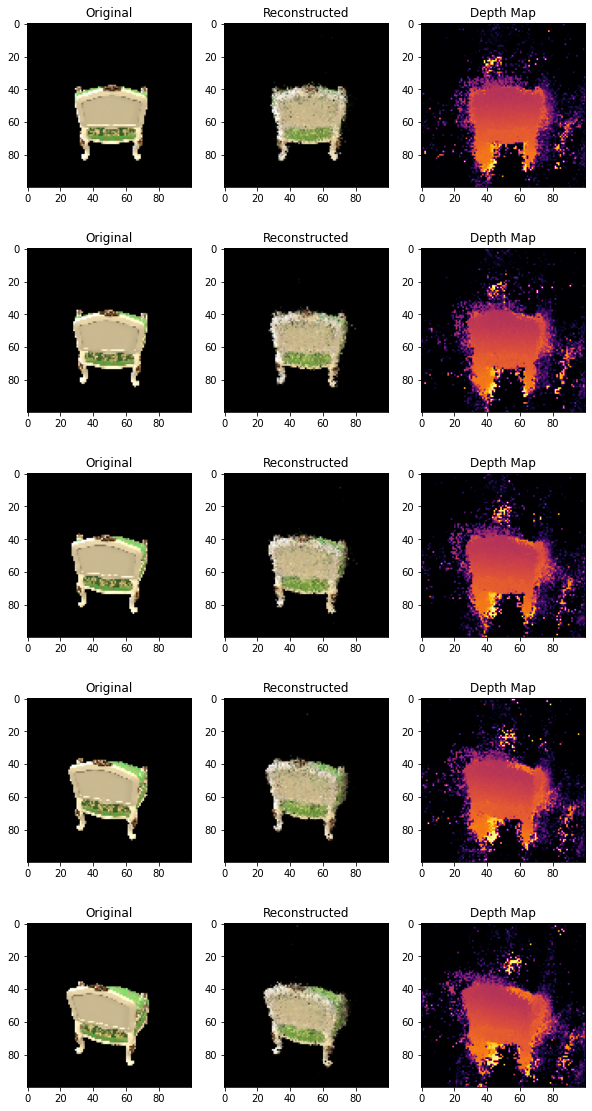

In [ ]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.preprocessing.image.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.preprocessing.image.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(
        keras.preprocessing.image.array_to_img(depth_map[..., None]), cmap="inferno"
    )
    ax[2].set_title("Depth Map")

In [ ]:
tf.keras.utils.save_img(f'{name}_reconstructed.png',test_recons_images[0])
tf.keras.utils.save_img(f'{name}_original.png',test_imgs[0])

## 360 degree

In [ ]:

def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, c2w in tqdm(enumerate(poses)):
# for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 360, endpoint=False))):
    # Get the camera to world matrix.
    # c2w = pose_spherical(theta, -20.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=1.8, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = f"rgb_video_{name}.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=9, macro_block_size=None)

1it [00:00,  1.40it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


6it [00:01,  4.58it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


11it [00:02,  5.64it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


16it [00:02,  6.14it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


21it [00:03,  6.41it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


26it [00:04,  6.58it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


31it [00:05,  6.65it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


36it [00:05,  6.75it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


41it [00:06,  6.80it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


46it [00:07,  6.84it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


51it [00:07,  6.87it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


56it [00:08,  6.87it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


61it [00:09,  6.86it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


66it [00:10,  6.87it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


71it [00:10,  6.87it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


76it [00:11,  6.88it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


81it [00:12,  6.76it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


86it [00:13,  6.80it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


91it [00:13,  6.83it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


96it [00:14,  6.86it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


101it [00:15,  6.89it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


106it [00:15,  6.89it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


111it [00:16,  6.89it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


116it [00:17,  6.89it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


121it [00:18,  6.90it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


126it [00:18,  6.79it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


131it [00:19,  6.83it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


136it [00:20,  6.86it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


141it [00:21,  6.87it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


146it [00:21,  6.88it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


151it [00:22,  6.90it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


156it [00:23,  6.90it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


161it [00:23,  6.90it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


166it [00:24,  6.90it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


171it [00:25,  6.89it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


176it [00:26,  6.77it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


181it [00:26,  6.82it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


186it [00:27,  6.85it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


191it [00:28,  6.87it/s]

(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)


200it [00:29,  6.86it/s]


(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
(100, 100, 40, 3)
(400000, 3)
rays_pos_encode shape :  (400000, 63)
